In [ ]:
!pip install rasterio

In [ ]:
import keras #idk how to use this one
import rasterio
from rasterio.plot import show
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import skimage
from pylab import imshow
import time
import pandas as pd

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn import svm
from sklearn.model_selection import train_test_split

import math

In [ ]:
#ndwi function
def ndwi_img(image):
  
  #ndwi = (B3-B8A)/(B3+B8A)

  #convert to float for division
  band3 = image[1].astype(float)
  band8a = image[4].astype(float)

  sub = np.subtract(band3, band8a)
  add = np.add(band3, band8a)
  ndwi = np.divide(sub, add, out=np.zeros_like(sub), where=add!=0)

  return ndwi

#rgb function
def rgb_img(image):
  rgb = np.dstack((image[2],image[1],image[0]))
  return rgb

In [ ]:
#surely pixel data should be image-preimage?

In [ ]:
#import training data (flood pixels)
f = open("floodpixels.txt")
fpixels = np.loadtxt(f)
f.close()

#non flood pixels
#temporarily change this because non flood pixels export isnt working as intended, this is to be selected
#f = open("nonfloodpixels.txt")
f = open("nonfloodpixels.txt")
nfpixels = np.loadtxt(f)
f.close()


#prestuff
#flood pixels
f = open("pfloodpixels.txt")
pfpixels = np.loadtxt(f)
f.close()

#non flood pixels
f = open("pnonfloodpixels.txt")
pnfpixels = np.loadtxt(f)
f.close()

##s1 stuff
f = open("floodpixelsS1.txt")
fpixelsS1 = np.loadtxt(f)
f.close()

f = open("nonfloodpixelsS1.txt")
nfpixelsS1 = np.loadtxt(f)
f.close()

fpixels = np.vstack([fpixels, fpixelsS1])
nfpixels = np.vstack([nfpixels, nfpixelsS1])


print(len(fpixels))
print(nfpixels)

In [ ]:
ndwifp = ndwi_img(fpixels)
ndwinfp = ndwi_img(nfpixels)

ndwipfp = ndwi_img(pfpixels)
ndwipnfp = ndwi_img(pnfpixels)

ndwidiff_fp = ndwifp - ndwipfp
ndwidiff_nfp = ndwinfp - ndwipnfp

print(ndwifp)
print(ndwinfp)

In [ ]:
print(type(fpixels[1][1]))
maxf = np.finfo('d').max
print(maxf)

In [ ]:
#define features
pixel_features = ["B2","B3","B4","B8","B8A","B11","ndwi","rgb"]#not being used
pixel_features_temp = ["B2","B3","B4","B8","B8A","B11","VH diff", "VV diff"] # need to add ndwi and rgb to output
image_features = ["flooded","nonflooded"]
#not really sure about these^

#target
pixel_target_names = ["no flood","flood"]
image_target_names = ["no flood","flood"]
target_id = [0,1]

In [ ]:
#append property names, target names and target id, then convert to pd dataframe

#convert to dataframe
df = pd.DataFrame(np.transpose(fpixels),columns=pixel_features_temp)


df["ndwi"] = ndwi_img(fpixels) - ndwi_img(pfpixels)
#rgb is 3d so the same method doesn't work
df["target"] = 1
df

In [ ]:
#non flood pixels
dnf = pd.DataFrame(np.transpose(nfpixels),columns=pixel_features_temp)
dnf["ndwi"] = ndwi_img(nfpixels)  - ndwi_img(pnfpixels)
dnf["target"] = 0
dnf

In [ ]:
#join dataframes
df_all = pd.concat([df,dnf], ignore_index=1)
df_all

In [ ]:
#separate into targets (kind of redundant but for readability)
df_all_0 = df_all[df_all.target==0]
df_all_1 = df_all[df_all.target==1]

#example plot of ndwi of flood pixels vs non flood pixels
plt.scatter(df_all_0["ndwi"],df_all_0["B2"], color="g", marker = "+")
plt.scatter(df_all_1["ndwi"],df_all_1["B2"], color="b", marker = ".")
plt.xlabel("ndwi")
plt.ylabel("B2")

In [ ]:
#same scatter, other way around
plt.scatter(df_all_1["ndwi"],df_all_1["B2"], color="b", marker = ".")
plt.scatter(df_all_0["ndwi"],df_all_0["B2"], color="g", marker = "+")
plt.xlabel("ndwi")
plt.ylabel("B2")

In [ ]:
#example plot of VV and VH differences
plt.scatter(df_all_0["VH diff"],df_all_0["VV diff"], color="g", marker = "+")
plt.scatter(df_all_1["VH diff"],df_all_1["VV diff"], color="b", marker = ".")
plt.xlabel("VH")
plt.ylabel("VV")

In [ ]:
#example plot of VV and VH differences
plt.scatter(df_all_1["VH diff"],df_all_1["VV diff"], color="b", marker = ".")
plt.scatter(df_all_0["VH diff"],df_all_0["VV diff"], color="g", marker = "+")
plt.xlabel("VH")
plt.ylabel("VV")

In [ ]:
#drop rows with all 0
df_all = df_all.loc[df_all.B2+df_all.B3+df_all.B4+df_all.B8+df_all.B8A+df_all.B11!=0].reset_index().drop(["index"], axis="columns")
df_all

In [ ]:
#Histograms
df_no_target = df_all.drop(["target"], axis="columns")
ncols = len(df_no_target.columns)
histarr = np.zeros(ncols)
i=0
for column in df_no_target:
  # Select column contents by column name using [] operator
  columnSeriesObj = df_all[column]
  print(column)
  hist = df_no_target[column].hist(bins=30)
  plt.show()
  i=i+1

In [ ]:
#remove the target column from dataframe
X = df_all.drop(["target"], axis="columns")
#X = X.drop(["B2","B3","B4","B8","B8A","B11","ndwi"], axis="columns")

#X = X.drop(["ndwi"], axis="columns")
#X.sort_values(by=["VH diff", "VV diff"], ascending=False)
X

In [ ]:
#illegal lol just for fun, sorting them by size and redifining them, obviously not good
#randomize order of each target section if u want as well - dont run this cell if you want actual data

X = X.abs().sort_values(by=["ndwi"], ascending=False, ignore_index=True)

#X = X.abs().sort_values(by=["VH diff"], ascending=False, ignore_index=True)
#X = X.abs().sort_values(by=["VV diff"], ascending=False, ignore_index=True)

X1 = X.head(int(920/2))
#plot
plt.scatter(X["ndwi"],X["ndwi"], color="g", marker = "+")
plt.scatter(X1["ndwi"],X1["ndwi"], color="b", marker = "+")


plt.xlabel("ndwi")
plt.ylabel("ndwi")

X = X.drop(["B2","B3","B4","B8","B8A","B11"], axis="columns")
X


In [ ]:
#dataframe of targets
y = df_all.target
y

In [ ]:
#set up training, test on size, train on (1-size) - vary somewhat
#smaller a, larger training size, should be more accurate but at some point,
#the amount of testing data becomes too little so a few misclassifications become
#a much larger proportion
a = 0.6
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=a)

print(len(X_train)) #(1-size) of total length
print(len(X_test))

In [ ]:
#classifier, play with parameters to get different accuracies
clf = svm.SVC(gamma="auto")

#clf = RandomForestClassifier()

#fit 
clf.fit(X_train, y_train)

#score
score = clf.score(X_test, y_test)

print(clf)

print(score*100,"%")

rs =  round(score*100, 3 - int(math.floor(math.log10(abs(score*100)))) - 1)
print(rs,"% (3sf)")

Redundant below, but some reusable

In [ ]:
##for SAR now

##IMPORTANT, currently only using dummy data


#import training data (flood pixels)
f = open("floodpixelsS1.txt")
fpixels = np.loadtxt(f)
f.close()

#non flood pixels
#temporarily change this because non flood pixels export isnt working as intended, this is to be selected
#f = open("nonfloodpixels.txt")
f = open("nonfloodpixelsS1.txt")
nfpixels = np.loadtxt(f)
f.close()


#features and target
pixel_features = ["VH","VV"]
#append property names, target names and target id, then convert to pd dataframe

pixel_target_names = ["no flood","flood"]
id_target = [0,1]


#convert to dataframe
df = pd.DataFrame(np.transpose(fpixels),columns=pixel_features)
df["target"] = 1
df

,VH,VV,target
0,-2.38270,-1.221953,1
1,-5.19354,-1.633780,1
2,-4.71779,2.189040,1
3,-3.84030,-5.724218,1
4,-2.04184,-3.220993,1
...,...,...,...
482,-3.17296,2.971202,1
483,2.41483,-0.581770,1
484,-3.55320,4.817410,1
485,4.99133,0.743372,1


In [ ]:
dnf = pd.DataFrame(np.transpose(nfpixels),columns=pixel_features)
dnf["target"] = 0
dnf

,VH,VV,target
0,396.0,388.0,0
1,334.0,340.0,0
2,455.0,469.0,0
3,338.0,567.0,0
4,428.0,425.0,0
...,...,...,...
1456,467.0,573.0,0
1457,543.0,843.0,0
1458,514.0,578.0,0
1459,280.0,386.0,0


In [ ]:
#join dataframes
df_all = pd.concat([df,dnf], ignore_index=1)
df_all

,VH,VV,target
0,0.0,0.0,1
1,0.0,0.0,1
2,0.0,0.0,1
3,0.0,0.0,1
4,0.0,0.0,1
...,...,...,...
1943,467.0,573.0,0
1944,543.0,843.0,0
1945,514.0,578.0,0
1946,280.0,386.0,0


Text(0, 0.5, 'VV')

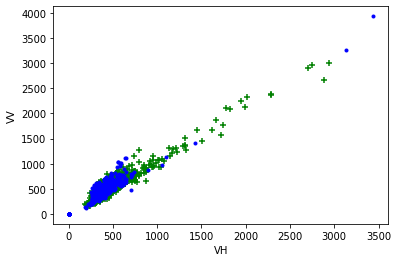

In [ ]:
#separate into targets (kind of redundant but for readability)
df_all_0 = df_all[df_all.target==0]
df_all_1 = df_all[df_all.target==1]

#example plot of ndwi of flood pixels vs non flood pixels
plt.scatter(df_all_0["VH"],df_all_0["VV"], color="g", marker = "+")
plt.scatter(df_all_1["VH"],df_all_1["VV"], color="b", marker = ".")
plt.xlabel("VH")
plt.ylabel("VV")

#nb - atm this is basically pointless but we can compare different data
#at the moment, it is 2 of the same plot because non flood pixels are being taken
#as flood pixels

In [ ]:
#remove the target column from dataframe
X = df_all.drop(["target"], axis="columns")
#X = X.drop(["ndwi"], axis="columns")
X

,VH,VV
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
...,...,...
1943,467.0,573.0
1944,543.0,843.0
1945,514.0,578.0
1946,280.0,386.0


In [ ]:
#dataframe of targets
y = df_all.target
y

0       1
1       1
2       1
3       1
4       1
       ..
1943    0
1944    0
1945    0
1946    0
1947    0
Name: target, Length: 1948, dtype: int64

In [ ]:
#set up training, test on size, train on (1-size) - vary somewhat
#smaller a, larger training size, should be more accurate but at some point,
#the amount of testing data becomes too little so a few misclassifications become
#a much larger proportion
a = 0.4
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=a)

len(X_train) #(1-size) of total length
len(X_test)

780

In [ ]:
#classifier, play with parameters to get different accuracies
clf = svm.SVC(gamma="auto")

#fit 
clf.fit(X_train, y_train)

#score
score = clf.score(X_test, y_test)

print(score*100,"%")

rs =  round(score*100, 3 - int(math.floor(math.log10(abs(score*100)))) - 1)
print(rs,"% (3sf)")

77.17948717948718 %
77.2 % (3sf)
